<a href="https://colab.research.google.com/github/jefernandezec/s2s/blob/main/S2S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentals of Survey-to-Survey Imputation

**1. Creating a dataset with a model-based consumption per capita**

Set seed for reproducibility and simulate raw variables

In [26]:
set.seed(1729)
n <- 1000

age             <- sample(18:79, n, replace = TRUE)
age_sq          <- age^2
house_ownership <- rbinom(n, 1, 0.6)   # 1 = owns house
employed    <- rbinom(n, 1, 0.7)   # 1 = employed
electricity     <- rbinom(n, 1, 0.8)   # 1 = has electricity
wallsbrick <- rbinom(n, 1, 0.75)   # 1 = walls material: brick
roofmetal  <- rbinom(n, 1, 0.25)   # 1 = roof material: brick
floordirt  <- rbinom(n, 1, 0.15)   # 1 = floor material: dirt
areaurban  <- rbinom(n, 1, 0.65)   # 1 = urban

df <- data.frame(
  age, age_sq, house_ownership, employed, electricity,
  wallsbrick,roofmetal,floordirt,areaurban
)

Define "actual" coefficients

In [27]:
base_coeffs <- c(
  age             = 0.03,
  age_sq          = -0.002,
  house_ownership = .5,
  employed    = 2,
  electricity     = .8,
  wallsbrick     =.3,
  roofmetal     = .4,
  floordirt     = -.5,
  areaurban    =.7
)

B_0 = 1

Simulate normal random noise and create per capita consumption

In [28]:
noise=rnorm(n)
#noise=rexp(n, rate = 1/10) - 10 #alternative for non-normal noise
base_coeffs = matrix(base_coeffs,ncol=1)

df$consumption_pc=exp(B_0 + as.matrix(df)%*%base_coeffs+noise) #using exp so the model can be estimated in log
#df$consumption_pc=as.matrix(df)%*%base_coeffs+noise #alternative for non-normal noise

head(df)

,age,age_sq,house_ownership,employed,electricity,wallsbrick,roofmetal,floordirt,areaurban,consumption_pc
,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,"<dbl[,1]>"
1,36,1296,1,1,1,0,0,0,1,1.219413e+01
2,75,5625,1,0,0,0,1,0,0,7.945271e-04
3,59,3481,0,0,1,0,0,0,1,5.447715e-02
4,62,3844,1,0,1,1,1,0,0,1.358692e-01
5,78,6084,1,1,1,0,0,0,0,2.865816e-03
6,60,3600,1,0,1,0,0,1,0,3.073831e-03


Visualize the density plot

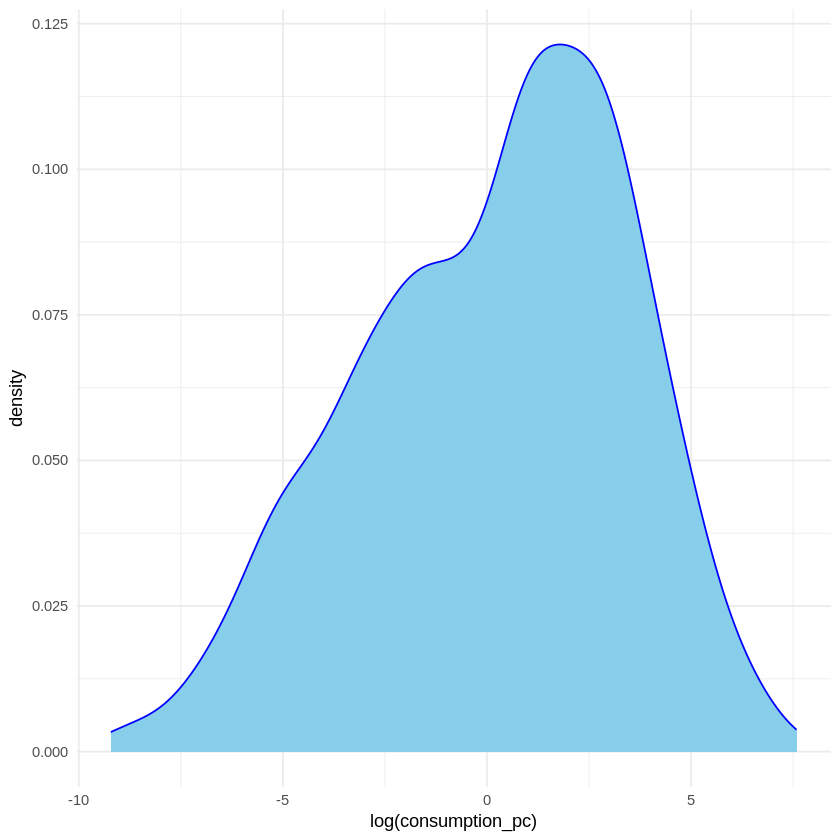

In [29]:
library(ggplot2)

ggplot(df, aes(x = log(consumption_pc))) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

Adjust linear model for consumption_pc

In [30]:
mod0=lm(log(consumption_pc) ~ . , df)
summary(mod0)


Call:
lm(formula = log(consumption_pc) ~ ., data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1972 -0.6643 -0.0179  0.7212  3.1749 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.599305   0.276563   5.783 9.84e-09 ***
age              0.009655   0.011220   0.861  0.38972    
age_sq          -0.001799   0.000114 -15.785  < 2e-16 ***
house_ownership  0.578756   0.066727   8.674  < 2e-16 ***
employed         1.982999   0.071288  27.817  < 2e-16 ***
electricity      0.696619   0.078960   8.822  < 2e-16 ***
wallsbrick       0.319004   0.077035   4.141 3.75e-05 ***
roofmetal        0.286098   0.074478   3.841  0.00013 ***
floordirt       -0.648626   0.089198  -7.272 7.20e-13 ***
areaurban        0.691384   0.069572   9.938  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.037 on 990 degrees of freedom
Multiple R-squared:  0.9009,	Adjusted R-squared:    0.9 
F-statistic: 99

Visualize residuals

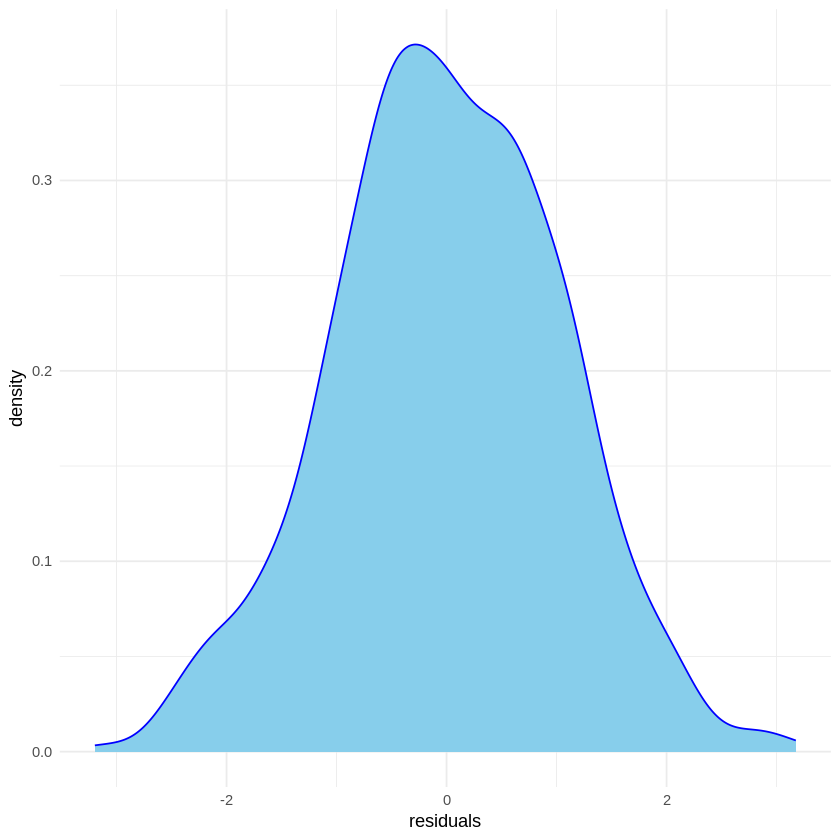

In [31]:
df$residuals = mod0$residuals

ggplot(df, aes(x = residuals)) +
  geom_density(fill = "skyblue", color = "blue") +
  theme_minimal()

df$residuals=NULL   # erasing current model's residuals

Turning more realistic: dropping two covariates

In [32]:
mod1=lm(log(consumption_pc) ~ age+age_sq+areaurban+electricity+house_ownership, df)
summary(mod1)


Call:
lm(formula = log(consumption_pc) ~ age + age_sq + areaurban + 
    electricity + house_ownership, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3893 -0.8596  0.1180  0.9931  3.8255 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.1049284  0.3566046   8.707  < 2e-16 ***
age              0.0133661  0.0151985   0.879    0.379    
age_sq          -0.0018364  0.0001544 -11.894  < 2e-16 ***
areaurban        0.7214973  0.0942420   7.656 4.54e-14 ***
electricity      0.7047967  0.1071296   6.579 7.65e-11 ***
house_ownership  0.5435019  0.0904789   6.007 2.65e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.406 on 994 degrees of freedom
Multiple R-squared:  0.8168,	Adjusted R-squared:  0.8159 
F-statistic: 886.2 on 5 and 994 DF,  p-value: < 2.2e-16
